In [2]:
using ProgressMeter
using JLD
using Random
include("../alpcahus.jl")
include("../helperFunctions.jl")
include("../cluster.jl")

hungarianAlgorithm (generic function with 1 method)

In [3]:
pwd()

"/home/javier/Desktop/alpcahus/goodpts"

In [4]:
D = 50 # ambient space dimension
d = 3 # subspace dimension
goodPoints = [5; 10; 20; 40; 80; 160] # good points per subspace
ν1 = 0.1 # noise variance good points
K = 2 # subspace count
varianceRatio = range( 1,300,5) # variance ratio for heatmaps
badPoints = 500
trials = 25; # smoother results
qValue = 24;
pointRatio = goodPoints

6-element Vector{Int64}:
   5
  10
  20
  40
  80
 160

In [4]:
seedVector1 = rand(Xoshiro(1234), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector2 = rand(Xoshiro(4321), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector3 = rand(Xoshiro(2143), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector4 = rand(Xoshiro(3412), 1:100000, trials*length(varianceRatio)*length(pointRatio));

In [5]:
ekssTensor = zeros(length(varianceRatio), length(pointRatio),trials)
alpcahTensor = zeros(length(varianceRatio), length(pointRatio),trials)
oracleTensor = zeros(length(varianceRatio), length(pointRatio),trials)

count = 1
@showprogress 1 "Running..." for i = 1:length(varianceRatio) # varianceRatio
     for j = 1:length(pointRatio) # prepend Threads.@threads for multi-threading
        for k = 1:trials
            # other parameters
            ν2 = varianceRatio[i]*ν1
            # subspace generation
            U1 = generateSubspace(D, d; seed=seedVector1[count]) 
            U2 = generateSubspace(D, d; seed=seedVector2[count])
            # data generation
            X1 = generateData(U1, [ν1,ν2], [goodPoints[j],badPoints]; seed=seedVector3[count])
            X2 = generateData(U2, [ν1,ν2], [goodPoints[j],badPoints]; seed=seedVector4[count])
            # complete data matrix
            X = hcat(X1,X2);
            # cluster assignments
            trueLabels = vec([1*ones(size(X1)[2],1); 2*ones(size(X2)[2],1)]);
            # ekss trial
            estimatedCluster = ALPCAHUS(X,K, [d,d]; B=128, q=qValue, T=3, subspaceMethod=:pca, finalStep=false)
            ekssTensor[i,j,k] = clusterError(trueLabels,estimatedCluster)
            # alpcahus trail
            estimatedCluster = ALPCAHUS(X,K, [d,d]; B=128, q=qValue, T=3, alpcahIter=20, subspaceMethod=:alpcah, finalStep=true, varfloor=1e-9, varianceMethod=:groupless) 
            alpcahTensor[i,j,k] = clusterError(trueLabels,estimatedCluster)
            # noisy oracle trial       
            noisyU1 = svd(X1[:,1:goodPoints[j]]).U[:,1:d]
            noisyU2 = svd(X2[:,1:goodPoints[j]]).U[:,1:d]
            estimatedCluster = clusterAssignment(X, [noisyU1, noisyU2], K)
            oracleTensor[i,j,k] = clusterError(trueLabels,estimatedCluster)
            # increase count
            count = count + 1
        end
    end
end

save("trialData.jld", "ekss", ekssTensor, "alpcah", alpcahTensor, "oracle", oracleTensor);

Running... 100%|█████████████████████████████████████████| Time: 3:19:41


In [5]:
trialData = load("trialData.jld")
ekssTensor = trialData["ekss"]
alpcahTensor = trialData["alpcah"]
oracleTensor = trialData["oracle"];

In [6]:
generateHeatmap2(goodPoints, varianceRatio, ekssTensor; plotType=:median, methodType="EKSS", ν1=ν1, badPoints=badPoints)
savefig("ekss_median.pdf")

"/home/javier/Desktop/alpcahus/goodpts_amount/ekss_median.pdf"

In [7]:
generateHeatmap2(goodPoints, varianceRatio, alpcahTensor; plotType=:median, methodType="ALPCAHUS", ν1=ν1, badPoints=badPoints)
savefig("alpcahus_median.pdf")

"/home/javier/Desktop/alpcahus/goodpts_amount/alpcahus_median.pdf"

In [8]:
generateHeatmap2(goodPoints, varianceRatio, oracleTensor; plotType=:median, methodType="Noisy Oracle", ν1=ν1, badPoints=badPoints)
savefig("oracle_median.pdf")

"/home/javier/Desktop/alpcahus/goodpts_amount/oracle_median.pdf"

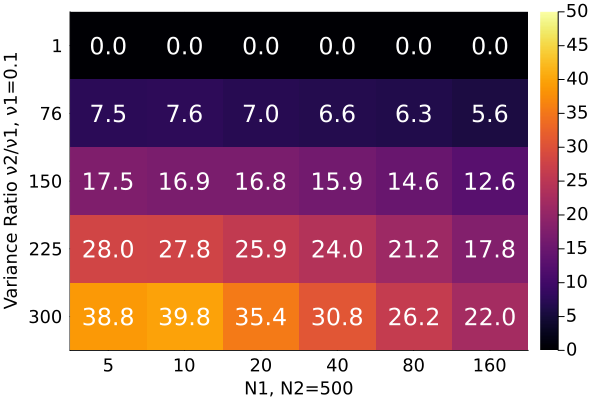

In [6]:
generateHeatmap2(goodPoints, varianceRatio, ekssTensor; plotType=:mean, methodType="EKSS", ν1=ν1, badPoints=badPoints)
#savefig("ekss_mean.pdf")

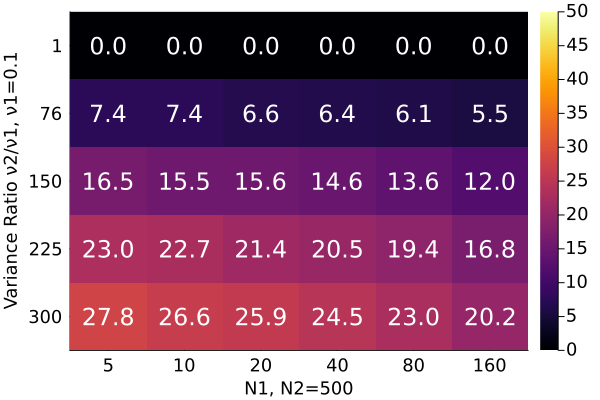

In [9]:
generateHeatmap2(goodPoints, varianceRatio, alpcahTensor; plotType=:mean, methodType="ALPCAHUS", ν1=ν1, badPoints=badPoints)
#savefig("alpcahus_mean.pdf")

In [32]:
newMatrix = round.(-mean(alpcahTensor,dims=3)[:,:,1] + mean(ekssTensor,dims=3)[:,:,1], digits=1)

5×6 Matrix{Float64}:
  0.0   0.0  0.0  0.0  0.0  0.0
  0.0   0.2  0.3  0.2  0.2  0.1
  0.9   1.4  1.3  1.2  1.0  0.6
  5.0   5.0  4.5  3.4  1.9  1.0
 11.0  13.2  9.6  6.2  3.2  1.8

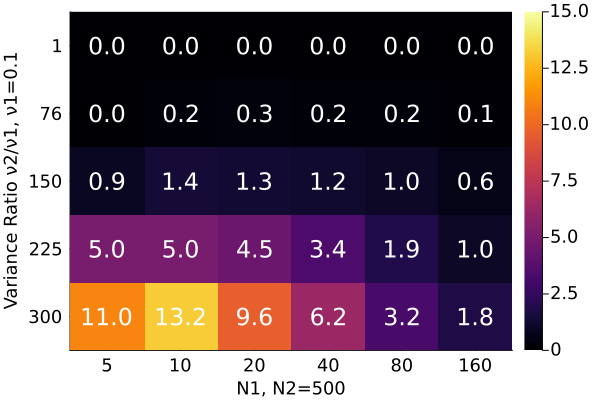

In [62]:
using Plots.PlotMeasures
x, y = goodPoints, varianceRatio
xRange=1:length(x)
    yRange=1:length(y)
    heatmap(newMatrix, title="", xlabel="N1, N2=$badPoints", ylabel="Variance Ratio ν2/ν1, ν1=$ν1",yflip=true, 
    xticks=(xRange,round.(Int,x)),yticks=(yRange,round.(Int,y)), clim=(0,15),
    legendfontpointsize=12,xtickfontsize=12,ytickfontsize=12,guidefontsize=12,titlefontsize=12, right_margin=5mm)
fontsize = 16
    nrow, ncol = size(newMatrix)
    ann = [(xRange[j],yRange[i], text(round(newMatrix[i,j], digits=1), fontsize, :white, :center)) for i in 1:nrow for j in 1:ncol]
    annotate!(ann, linecolor=:white)
#savefig("goodpts_ratio.pdf")

In [11]:
generateHeatmap2(goodPoints, varianceRatio, oracleTensor; plotType=:mean, methodType="Noisy Oracle", ν1=ν1, badPoints=badPoints)
savefig("oracle_mean.pdf")

"/home/javier/Desktop/alpcahus/goodpts_amount/oracle_mean.pdf"

In [12]:
generateHeatmap2(goodPoints, varianceRatio, ekssTensor; plotType=:variance, methodType="EKSS", ν1=ν1, badPoints=badPoints)
savefig("ekss_variance.pdf")

"/home/javier/Desktop/alpcahus/goodpts_amount/ekss_variance.pdf"

In [13]:
generateHeatmap2(goodPoints, varianceRatio, alpcahTensor; plotType=:variance, methodType="ALPCAHUS", ν1=ν1, badPoints=badPoints)
savefig("alpcahus_variance.pdf")

"/home/javier/Desktop/alpcahus/goodpts_amount/alpcahus_variance.pdf"

In [14]:
generateHeatmap2(goodPoints, varianceRatio, oracleTensor; plotType=:variance, methodType="Noisy Oracle", ν1=ν1, badPoints=badPoints)
savefig("oracle_variance.pdf")

"/home/javier/Desktop/alpcahus/goodpts_amount/oracle_variance.pdf"